# Подключаем необходимые библиотеки

In [2]:
import torch
import torchvision
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

C:\Users\davyd\AppData\Local\Temp\ipykernel_18824\587186670.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Подключим видеокарту

In [2]:
gpu = torch.cuda.is_available()

if gpu==True:
    print("Обучение на видеокарточке")
else:
    print('Обучение на процессоре')

Обучение на видеокарточке


# Проведем осмотр данных

Выведем общую фотографию всех персонажей , которых мы собираемся классифицировать

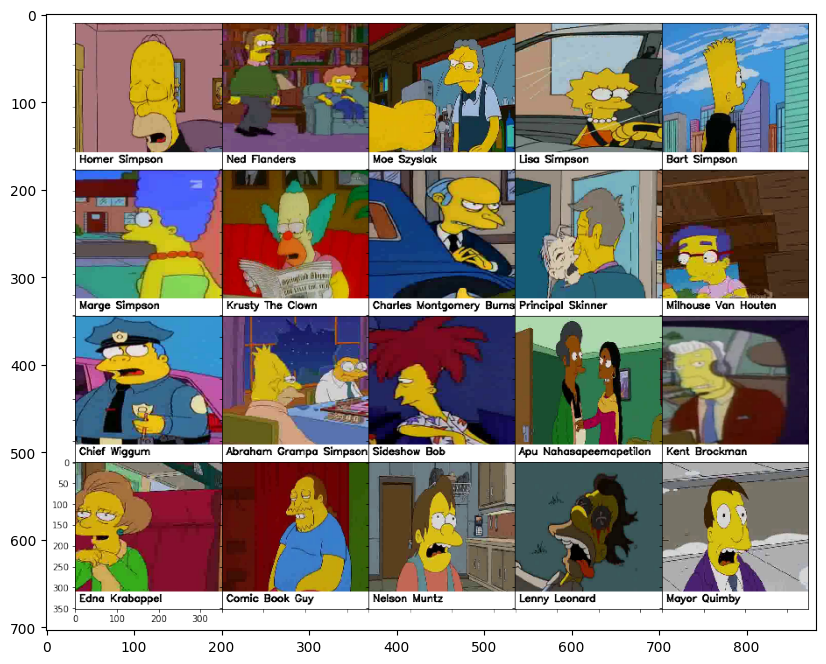

In [2]:
img = Image.open(r'C:\Users\davyd\Downloads\PYTORCH\Simpsons\characters_illustration.png')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
ax.imshow(img)
plt.show()

# Проанализируем наш датасет 

## Выведем график по количеству данных в каждом классе 

In [79]:
TRAIN_PATH = Path('C:/Users/davyd/Downloads/PYTORCH/Simpsons/train/simpsons_dataset/')

train_fuck = sorted(list(TRAIN_PATH.rglob('*.jpg')))
train_fuck_labels = [path.parent.name for path in train_fuck]

In [80]:
data = pd.Series(train_fuck_labels).value_counts().sort_values().to_frame("count")
data["class"] = data.index
data = data.reset_index(drop=True)
data=data.drop(1)
data = data.reset_index(drop=True)
data["index"]=data.index

In [81]:
data

,count,class,index
0,3,lionel_hutz,0
1,8,disco_stu,1
2,8,troy_mcclure,2
3,17,miss_hoover,3
4,27,gil,4
5,27,fat_tony,5
6,32,otto_mann,6
7,40,sideshow_mel,7
8,42,agnes_skinner,8
9,45,rainier_wolfcastle,9


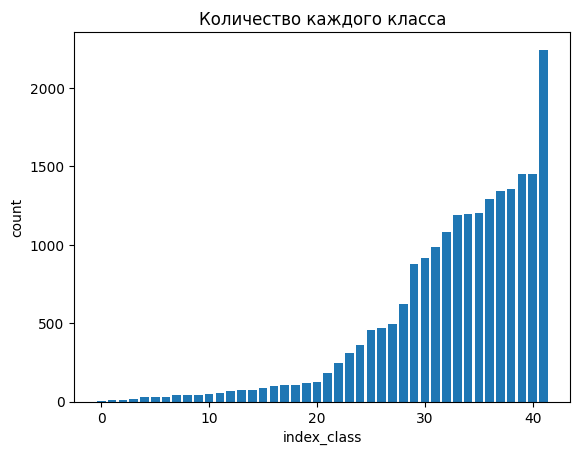

In [82]:
plt.bar(data["index"], data["count"])
plt.xlabel("index_class")
plt.ylabel("count")
plt.title("Количество каждого класса")
plt.show()

У нас некоторых классов черезвычайно мало, чтобы модель лучше обучилась нам потребуется Аугментировать наши картинки

# Начнем подготовку нашего датасета для обучения

## Создадим датасет для обучения нашей модели

In [3]:
files=os.walk("C:/Users/davyd/Downloads/PYTORCH/Simpsons/train/simpsons_dataset/")

In [4]:
count=0

In [5]:
paths = []

In [6]:
for path in files:
    count += 1
    if count == 1:
        continue
    dir_path = path[0]
    subdir_paths = path[2]
    subdir_paths = list(map(lambda x: dir_path + '/' + x, subdir_paths))
    paths.extend(subdir_paths)

Создадим класс Dataset для создания датасета 

In [7]:
class2id = {name:i for i, name in enumerate(os.listdir('C:/Users/davyd/Downloads/PYTORCH/Simpsons/train/simpsons_dataset/'))}
id2class = {i:name for name, i in class2id.items()}

In [8]:
id2class

{0: 'abraham_grampa_simpson',
 1: 'agnes_skinner',
 2: 'apu_nahasapeemapetilon',
 3: 'barney_gumble',
 4: 'bart_simpson',
 5: 'carl_carlson',
 6: 'charles_montgomery_burns',
 7: 'chief_wiggum',
 8: 'cletus_spuckler',
 9: 'comic_book_guy',
 10: 'disco_stu',
 11: 'edna_krabappel',
 12: 'fat_tony',
 13: 'gil',
 14: 'groundskeeper_willie',
 15: 'homer_simpson',
 16: 'kent_brockman',
 17: 'krusty_the_clown',
 18: 'lenny_leonard',
 19: 'lionel_hutz',
 20: 'lisa_simpson',
 21: 'maggie_simpson',
 22: 'marge_simpson',
 23: 'martin_prince',
 24: 'mayor_quimby',
 25: 'milhouse_van_houten',
 26: 'miss_hoover',
 27: 'moe_szyslak',
 28: 'ned_flanders',
 29: 'nelson_muntz',
 30: 'otto_mann',
 31: 'patty_bouvier',
 32: 'principal_skinner',
 33: 'professor_john_frink',
 34: 'rainier_wolfcastle',
 35: 'ralph_wiggum',
 36: 'selma_bouvier',
 37: 'sideshow_bob',
 38: 'sideshow_mel',
 39: 'snake_jailbird',
 40: 'troy_mcclure',
 41: 'waylon_smithers'}

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, class2id):
        super().__init__()
        self.paths=paths
        self.class2id=class2id
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,i):
        img=torchvision.io.read_image(self.paths[i])
        
        '''augmentations =  torchvision.transforms.RandomChoice([
        torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop(size=300),
        torchvision.transforms.RandomCrop(250)]),
        torchvision.transforms.RandomRotation(degrees=(-25, 25)),
        torchvision.transforms.RandomHorizontalFlip(p=1),])'''
        transforms= torchvision.transforms.Compose([
                                                     torchvision.transforms.Resize(size=(250,250)),
                                                     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
                                                    ])
            
        return transforms(img/255), self.class2id[self.paths[i].split('/')[-2]]

In [10]:
train,test=train_test_split(paths, test_size=0.1)

In [11]:
train_dataset=Dataset(train, class2id)
test_dataset=Dataset(test, class2id)

In [12]:
len(train_dataset)

18839

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False)

# Создание модели при помощи Conv2d и Linear

In [14]:
class CNN_Simpsons(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=96, kernel_size=2, stride=3),
            torch.nn.ReLU(),
        )
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(in_features=96*3*3, out_features=600, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=600, out_features=42, bias=False),
        )
        
    def forward(self, x):
        x = self.cnn(x)
        x = self.mlp(x.flatten(start_dim=1))
        return x

In [15]:
model=CNN_Simpsons()

In [16]:
model(train_dataset[0][0].unsqueeze(dim=0)).shape

torch.Size([1, 42])

# Обучение модели

## Функция для обучения модели на одну эпоху

In [70]:
def learn_one_epochs(model, train_dataloader, test_dataloader, optimizer, loss_function, device):
    model.to(device)
    train_losses = []
    test_losses = []
    train_f1_score = []
    test_f1_score = []
    model.train()#режим обучения модели
    for img , res in tqdm(train_dataloader):
        
        img=img.to(device)
        res=res.to(device)
        optimizer.zero_grad()
        prediction=model(img)
        loss=loss_function(prediction ,res)
        train_f1_score=f1_score(res, prediction.argmax(),average='macro')
        train_losses.append((loss / len(train_dataloader)).to("cpu"))     
        loss.backward()
        optimizer.step()
        
        
    model.eval()
    for img, res in tqdm(test_dataloader):
        img=img.to(device)
        res=res.to(device)
        prediction=model(img)
        loss=loss_function(prediction, res)
        test_f1_score=f1_score(res, prediction.argmax(),average='macro')
        test_losses.append((loss /len(test_dataloader)).to("cpu"))
    
    print(f'''
        Train Loss: {sum(train_losses)}
        Train F1: {sum(train_f1_score)}
        Test Loss: {sum(test_losses)}
        Test F1: {sum(test_f1_score)}
        ''')
    
    return sum(train_losses), sum(test_losses), train_f1_score, test_f1_score

## Обучаем модель

In [71]:
model=CNN_Simpsons()
train=train_dataloader
test=test_dataloader
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
loss_function=torch.nn.CrossEntropyLoss()
device="cuda"
epochs=1

In [72]:
!nvidia-smi

Thu Feb  8 23:09:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.29                 Driver Version: 546.29       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8              20W / 165W |   1778MiB / 16380MiB |     21%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [73]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
for epoch_i in (range(epochs)):
    epoch_train_losses, epoch_test_losses, epoch_train_accuracy, epoch_test_accuracy = learn_one_epochs(
        model,
        train_dataloader,
        test_dataloader,
        optimizer,
        loss_function,
        device
    )
    train_losses.append(epoch_train_losses)
    test_losses.append(epoch_test_losses)
    train_accuracy.append(epoch_train_accuracy)
    test_accuracy.append(epoch_test_accuracy)
    print(epoch_i+1)

  0%|                                                                                          | 0/589 [00:00<?, ?it/s]


TypeError: Singleton array tensor(265, device='cuda:0') cannot be considered a valid collection.